# Network of Words

In [31]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize,sent_tokenize,Text,PorterStemmer,WordNetLemmatizer,pos_tag
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import networkx as nx
import math
import matplotlib.pyplot as plt
import spacy
from spellchecker import SpellChecker
import collections as clt
import time
from community import best_partition
import pickle
import math
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [1]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub('&lt;/?.*?&gt;',' &lt;&gt; ', text)
    text = re.sub('(\\d|\\W)+',' ',text)
    return text

In [60]:
df = pd.read_csv('reviews_full_v5.csv')
df = df[df['Score'] >= 75]
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots
sp = spacy.load('en_core_web_sm')
df.reset_index(drop=True, inplace=True)
df

,User,Date,Year,Month,Release,Band,Score,Link,Album_link,Review_title,Genre,Text,Sentiment
0,SpookyApparition,July 11 2002,2002,7,Chaosphere,Meshuggah,82,https://www.metal-archives.com/reviews/Meshugg...,https://www.metal-archives.com/albums/Meshugga...,Technical metal at it's finest.,technical thrash metal|math metal|progressive ...,I originally bought Chaosphere in late 2000......,0.9728
1,SpookyApparition,July 14 2002,2002,7,Necroticism_-_Descanting_the_Insalubrious,Carcass,88,https://www.metal-archives.com/reviews/Carcass...,https://www.metal-archives.com/albums/Carcass/...,Carcass at their finest.,grindcore|melodic death metal,A midpoint between Carcass' early grind albums...,0.8479
2,MarkRyan,July 15 2002,2002,7,Angels_Fall_First,Nightwish,90,https://www.metal-archives.com/reviews/Nightwi...,https://www.metal-archives.com/albums/Nightwis...,On par with their other stuff...,symphonic power metal,"I'm not hard-core into metal at all, really, b...",0.9951
3,Fear,July 16 2002,2002,7,Dark_Genesis,Iced_Earth,87,https://www.metal-archives.com/reviews/Iced_Ea...,https://www.metal-archives.com/albums/Iced_Ear...,Brilliance in Repackaging,heavy metal|us power metal,"This is not a new album, but in fact, five alb...",0.9976
4,Demented666,July 18 2002,2002,7,Extension_of_the_Wish,Andromeda,100,https://www.metal-archives.com/reviews/Androme...,https://www.metal-archives.com/albums/Andromed...,A smashing debut.,progressive metal,Andromeda's Extension of the Wish- clearly one...,0.8619
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64636,TheStormIRide,June 30 2017,2017,6,Flying_Above_Ancient_Ruins,Krolok,85,https://www.metal-archives.com/reviews/Krolok/...,https://www.metal-archives.com/albums/Krolok/F...,Feverish Nightmares of Yore,atmospheric black metal,"Formed in 2011 by HV, Krolok is an atmospheric...",0.5875
64637,6CORPSE6GRINDER6,June 30 2017,2017,6,Chemical_Assault,Violator,85,https://www.metal-archives.com/reviews/Violato...,https://www.metal-archives.com/albums/Violator...,"Take your life back, in the pit!",thrash metal,I don't have any issues with the retro-thrash ...,0.9976
64638,6CORPSE6GRINDER6,June 30 2017,2017,6,Violent_Mosh,Violator,80,https://www.metal-archives.com/reviews/Violato...,https://www.metal-archives.com/albums/Violator...,Officers are dirtier than the criminals they c...,thrash metal,This band was so important for the thrash meta...,0.9911
64639,Wacke,June 30 2017,2017,6,Resurrection,Chimaira,89,https://www.metal-archives.com/reviews/Chimair...,https://www.metal-archives.com/albums/Chimaira...,What doesn't kill us makes us stronger.,hard rock,Chimaira is arguably the most overlooked and/o...,0.9947


In [61]:
preprocess_text(df['Text'][0])

'i originally bought chaosphere in late and hated it i could rarely sit through the entire album and regretted paying for it all of the songs sounded the same without any variation but as time has passed i ve grown to appreciate it more and more the technicality is truly astounding outshining by and large the entire metal genre thordendahl and haake are among the top performers at their respective instruments guitars drums and the remaining members are more than competent the bass playing is more evident than on most metal albums and along with the guitars it creates one huge crunching rhythm while haake often blasts away in a different time signature on his kit kidman s vocal lines tie in with the music better than just about any album i can think of although i can t describe it as well as i would like he stresses syllables on words on certain drum hits and lots of small things like that which make for a very technical vocal performance something not often seen in extreme metal and la

In [69]:
def isNaN(x):
    return x != x

In [7]:
genre_group = pickle.load(open('genre_group.p','rb'))

In [ ]:
B = nx.Graph()
#stemmer = PorterStemmer() #faster
#stemmer = WordNetLemmatizer() #slower but more accurate
vocab = set()
a = time.time()
spell = SpellChecker()
N_albums = len(set(df.Release))
all_stopwords = sp.Defaults.stop_words
tf = {}
for index, row in df.iterrows():
    if index%5000 == 0:
        print(index, time.time()-a)
    text = pos_tag(word_tokenize(row['Review_title'] + ' ' + row['Text']))#both title and text
    album = row['Release'] + 'A'
    if isNaN(row['Genre']):
        genres = []
    else:
        genres = list({genre_group[item] for item in row['Genre'].split('|')})
    #print(text)
    #print(genres)
    for word,tag in text:
        #print(word)
        word = word.lower()
        if word.isalpha() and len(word) > 4 and len(word) < 15 and tag == 'JJ' and word not in all_stopwords and len(spell.unknown([word])) == 0:
            if not B.has_edge(album, word):
                B.add_edge(album, word, weight = 1)
            else:
                B[album][word]['weight'] += 1
            vocab.add(word)
            for genre in genres:
                if genre not in tf:
                    tf[genre] = {}
                if word not in tf[genre]:
                    tf[genre][word] = 1
                else:
                    tf[genre][word] += 1
print(B.number_of_nodes(), B.number_of_edges(),time.time()-a)

In [ ]:
G = nx.Graph() #eliminates lone words
for word in vocab:
    for album in B.adj[word]:
        for word1 in B.adj[album]:
            if word < word1: #order is important to avoid repeats
                if not G.has_edge(word,word1):
                    G.add_edge(word, word1, weight = 0)
                G[word][word1]['weight'] += 1

In [5]:
#nx.write_gpickle(B,'bipartite_wordsv3.p')
#nx.write_gpickle(G,'network_wordsv3.p')

In [7]:
vocab = set(open('vocab_list.txt', 'r').read().split('\n'))

In [8]:
G = nx.read_gpickle('network_wordsv2.p')
B = nx.read_gpickle('bipartite_wordsv2.p')

In [9]:
G.number_of_nodes(), B.number_of_nodes(), len(vocab)

(16033, 45464, 16034)

In [10]:
N_albums = B.number_of_nodes() - len(vocab)
N_albums

29430

In [11]:
len(set(df.Release))

40241

In [75]:
idf = pickle.load(open('IDF.p','rb'))
tf = pickle.load(open('TF.p','rb'))

In [35]:
'''idf = {} # for genre
for item in tf:
    for word in tf[item]:
        if word not in idf:
            idf[word] = 1
        else:
            idf[word] += 1
for word in idf:
    idf[word] = math.log(len(genre_group)/idf[word])'''

In [76]:
tfidf = {}
genres = set(genre_group.values())
for genre in genres:
    total = 0
    tfidf[genre] = {}
    for word in tf[genre]:
        total += tf[genre][word]
    for word in tf[genre]:
        tfidf[genre][word] = (tf[genre][word] / total) * idf[word]

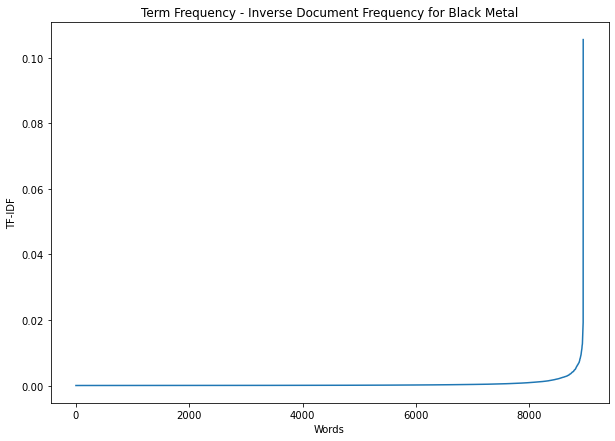

In [71]:
plt.title('Term Frequency - Inverse Document Frequency for Black Metal')
plt.ylabel('TF-IDF')
plt.xlabel('Words')
plt.plot(sorted(list(tfidf['Black metal'].values())))
plt.savefig('TF-IDF of Black Metal.png')

In [52]:
tmp = sorted(list(tfidf['Black metal'].values()))

In [42]:
def fragment(inp):
    inp = sorted(inp)
    total = sum(inp)
    return -1*sum([(x/total)*math.log(x/total) for x in inp])

In [49]:
fragment([1,1,1,1,1,1,5])

1.666332585328325

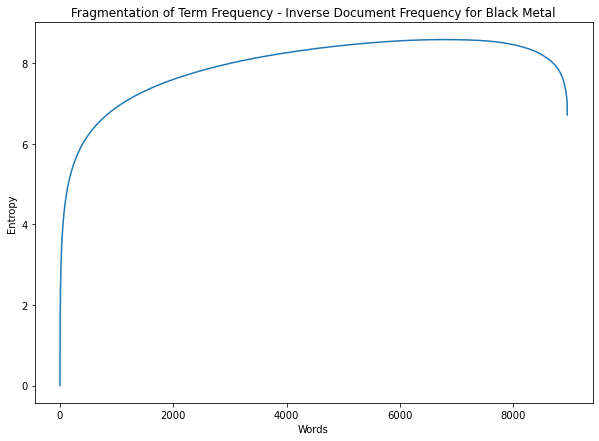

In [73]:
plt.title('Fragmentation of Term Frequency - Inverse Document Frequency for Black Metal')
plt.ylabel('Entropy')
plt.xlabel('Words')
plt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])
plt.show()
#find maximum

In [77]:
genre = 'Black metal'
print([key for key in tfidf[genre] if tfidf[genre][key] > 0.01])

['heavy', 'melodic', 'excellent', 'great', 'early', 'unique', 'black', 'overall', 'atmospheric', 'musical', 'different', 'extreme', 'ambient', 'entire', 'strong', 'clear', 'harsh', 'simple', 'clean', 'original', 'vocal', 'second', 'similar', 'little', 'previous', 'short', 'powerful', 'acoustic', 'interesting', 'beautiful', 'album', 'norwegian', 'perfect', 'symphonic', 'depressive']


In [62]:
idf['great'], idf['technical'], tf['Black metal']['great'], tf['Black metal']['technical']

(0.8403579413442236, 2.1461568355093625, 7431, 1207)

In [39]:
genre = 'Thrash metal'
print([key for key in tfidf[genre] if tfidf[genre][key] > 0.01])

['entire', 'different', 'vocal', 'technical', 'extreme', 'impressive', 'thrash', 'great', 'melodic', 'pretty', 'catchy', 'short', 'acoustic', 'classic', 'early', 'heavy', 'perfect', 'similar', 'little', 'awesome', 'previous', 'right', 'metal', 'original', 'brutal', 'intense', 'excellent', 'second', 'aggressive', 'instrumental', 'german', 'overall', 'unique', 'progressive', 'modern', 'clean', 'black', 'album', 'single', 'interesting', 'amazing', 'memorable', 'musical', 'strong', 'solid', 'simple', 'clear', 'powerful', 'favorite']


In [32]:
genre = 'Progressive metal'
print([key for key in tfidf[genre] if tfidf[genre][key] > 0.01])

['entire', 'different', 'vocal', 'technical', 'impressive', 'progressive', 'excellent', 'brilliant', 'melodic', 'unique', 'short', 'overall', 'strong', 'second', 'incredible', 'great', 'beautiful', 'fantastic', 'catchy', 'previous', 'metal', 'simple', 'instrumental', 'perfect', 'awesome', 'clean', 'powerful', 'little', 'single', 'heavy', 'amazing', 'emotional', 'acoustic', 'favorite', 'interesting', 'solid', 'similar', 'album', 'original', 'complex', 'memorable', 'classic', 'musical', 'atmospheric', 'modern']


In [17]:
genre = 'Folk metal'
print([key for key in tfidf[genre] if tfidf[genre][key] > 0.01])

['unique', 'favorite', 'different', 'metal', 'catchy', 'short', 'early', 'great', 'vocal', 'single', 'amazing', 'heavy', 'clean', 'emotional', 'acoustic', 'interesting', 'finnish', 'powerful', 'traditional', 'perfect', 'entire', 'folky', 'strong', 'progressive', 'symphonic', 'female', 'original', 'atmospheric', 'black', 'instrumental', 'beautiful', 'musical', 'excellent', 'melodic', 'previous', 'similar', 'album', 'overall', 'second', 'irish', 'little', 'pagan', 'harsh', 'electric', 'simple']


In [33]:
genre = 'Gothic metal'
print([key for key in tfidf[genre] if tfidf[genre][key] > 0.01])

['second', 'original', 'heavy', 'melodic', 'vocal', 'single', 'unique', 'little', 'great', 'favorite', 'previous', 'powerful', 'industrial', 'strong', 'clean', 'amazing', 'early', 'electronic', 'excellent', 'memorable', 'perfect', 'short', 'different', 'symphonic', 'overall', 'interesting', 'gothic', 'beautiful', 'progressive', 'album', 'catchy', 'harsh', 'draconian', 'female', 'emotional', 'atmospheric', 'operatic', 'acoustic', 'instrumental', 'similar', 'clear', 'black', 'simple', 'entire', 'musical', 'special', 'melancholic']


In [34]:
genre = 'Doom metal'
print([key for key in tfidf[genre] if tfidf[genre][key] > 0.01])

['little', 'black', 'similar', 'atmospheric', 'original', 'musical', 'heavy', 'psychedelic', 'short', 'early', 'vocal', 'melodic', 'perfect', 'unique', 'great', 'second', 'classic', 'single', 'clean', 'powerful', 'strong', 'overall', 'different', 'instrumental', 'interesting', 'excellent', 'previous', 'entire', 'beautiful', 'melancholic', 'traditional', 'album', 'emotional', 'acoustic', 'depressive', 'massive', 'simple', 'clear', 'female', 'gothic', 'funeral']


network of words based on same album/genre/review
network of words based on same sentence 
network of bigrams/trigrams 